In [1]:
import numpy as np
def generate_n_body_initial_conditions(n, seed=42, xlim=(-1, 1), ylim=(-1, 1), vlim=(0, 0.5)):
    np.random.seed(seed)
    x = np.random.uniform(*xlim, size=n)
    y = np.zeros(n)
    #y = np.random.uniform(*ylim, size=n)
    #Vx = np.random.uniform(*vlim, size=n)
    Vx = np.zeros(n)
    Vy = np.random.uniform(*vlim, size=n)
    return np.column_stack((x, y, Vx, Vy))

# Solar System initial conditions

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

G = 39.478  # Гравитационная постоянная в AU^3 / (Масса_Солнца * год^2)

# Массы (в массах Солнца) и радиусы орбит (в а.е.), скорости (в а.е/год)
bodies = {
    "Sun":      (1.0, 0.0, 0.0),
    "Mercury":  (1.65e-7, 0.39, 10.1),
    "Venus":    (2.45e-6, 0.72, 7.4),
    "Earth":    (3.00e-6, 1.00, 6.3),
    "Mars":     (3.2e-7, 1.52, 5.1),
    "Jupiter":  (9.55e-4, 5.20, 2.7),
    "Saturn":   (2.86e-4, 9.58, 2.0),
    "Uranus":   (4.37e-5, 19.22, 1.4),
    "Neptune":  (5.15e-5, 30.05, 1.1),
    #"Pluto":    (6.5e-9, 40.05, 0.945),
}

# Количество тел
n: int = len(bodies)

# Формируем массив масс и начальные условия
masses = np.array([bodies[planet][0] for planet in bodies], dtype=np.float64)

# Начальные условия: (x, y, Vx, Vy)
initial_conditions = []
for i, (planet, (mass, r, V)) in enumerate(bodies.items()):
    x = r
    y = 0
    Vx = 0
    Vy = np.sqrt(G * masses[0] / r) if planet != "Sun" else 0  # Только планеты имеют орбитальную скорость
    initial_conditions.append([x, y, Vx, Vy])

initial_conditions = np.array(initial_conditions, dtype=np.float64)
T_max: int = 200
dT: float = 0.01

# Solar System with odeint

In [3]:
def n_body_equations_odeint(state, t, n, masses):
    """Функция для odeint, описывающая уравнения движения n тел."""
    state = state.reshape(n, 4)
    derivatives = np.zeros_like(state)

    n = len(state)
    # Позиции и скорости
    pos = state[:, :2]   # (n, 2)
    vel = state[:, 2:]   # (n, 2)

    # Заполняем производные скоростей (dx/dt = vx, dy/dt = vy)
    derivatives[:, :2] = vel

    # Расчёт ускорений
    for i in range(n):
        r_i = pos[i]  # (2,)
        diff = pos - r_i  # (n, 2)
        dist = np.linalg.norm(diff, axis=1) + 1e-5  # (n,)
        
        # Удаляем вклад тела i в суммирование
        mask = np.arange(n) != i
        diff = diff[mask]             # (n-1, 2)
        dist = dist[mask]             # (n-1,)
        m = masses[mask]              # (n-1,)

        # Ускорение: G * m / r^3 * dr
        accel = (G * m / dist**3)[:, np.newaxis] * diff  # (n-1, 2)
        total_accel = np.sum(accel, axis=0)

        derivatives[i, 2:] = total_accel

    return derivatives.flatten()

def solve_n_body(n, masses, initial_conditions, t_max=50, dt=dT):
    """Решает задачу n тел и возвращает траектории."""
    t = np.arange(0, t_max, dt)
    sol = odeint(n_body_equations_odeint, initial_conditions.flatten(), t, args=(n, masses))
    return sol.reshape(-1, n, 4)

In [13]:
trajectories_odeint = solve_n_body(n, masses, initial_conditions,t_max=200)

In [ ]:
np.save(f"saved_trajectories/Trajectories_odeint_{T_max}_{dT}.npy", trajectories_odeint)

# Solar System with solve_ivp

In [4]:
def n_body_equations_ivp(t, y, n, masses):
    state = y.reshape(n, 4)
    derivatives = np.zeros_like(state)

    pos = state[:, :2]
    vel = state[:, 2:]

    derivatives[:, :2] = vel

    for i in range(n):
        r_i = pos[i]
        diff = pos - r_i
        dist = np.linalg.norm(diff, axis=1) + 1e-5

        mask = np.arange(n) != i
        diff = diff[mask]
        dist = dist[mask]
        m = masses[mask]

        accel = (G * m / dist**3)[:, np.newaxis] * diff
        derivatives[i, 2:] = np.sum(accel, axis=0)

    return derivatives.flatten()

def solve_n_body(n, masses, initial_conditions, t_max=50, dt=0.01):
    """Решает задачу n тел и возвращает траектории, используя solve_ivp."""
    t_span = (0, t_max)
    t_eval = np.arange(0, t_max, dt)
    y0 = initial_conditions.flatten()
    sol = solve_ivp(
        n_body_equations_ivp,
        t_span,
        y0,
        args=(n, masses),
        t_eval=t_eval,
        method='DOP853',
        rtol=1e-9,
        atol=1e-9
    )
    return sol.y.T.reshape(-1, n, 4)

In [14]:
trajectories_ivp = solve_n_body(n, masses, initial_conditions,t_max=200)

In [ ]:
np.save(f"saved_trajectories/Trajectories_ivp_{T_max}_{dT}.npy", trajectories_ivp)

# Solar system wiht Verlet method

In [5]:
# initial conditions
steps = int(T_max / dT)
positions = initial_conditions[:, :2]
velocities = initial_conditions[:, 2:]

In [6]:
# part used in multiple places
merge_threshold = 0.015 

def merge_bodies(positions, velocities, masses):
    n = len(masses)
    
    for i in range(n):
        if masses[i] == 0:
            continue
        for j in range(i + 1, n):
            if masses[j] == 0:
                continue
            if np.linalg.norm(positions[i] - positions[j]) < merge_threshold:
                total_mass = masses[i] + masses[j]
                positions[i] = (masses[i] * positions[i] + masses[j] * positions[j]) / total_mass
                velocities[i] = (masses[i] * velocities[i] + masses[j] * velocities[j]) / total_mass
                masses[i] += masses[j]
                velocities[i] = 0
                masses[j] = 0
                break
    
    return positions, velocities, masses

In [7]:
def compute_accelerations(positions, masses):

    n = len(masses)
    accelerations = np.zeros_like(positions)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r = np.linalg.norm(r_vec)
                if r > 0:
                    accelerations[i] += G * masses[j] * r_vec / r**3

    return accelerations


def verlet_integration(n, masses, positions, velocities, dt, steps):
    positions_history = np.zeros((steps, positions.shape[0], positions.shape[1]),dtype=np.float64)
    accelerations = compute_accelerations(positions, masses)
    
    for i in range(steps):
        new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
        new_accelerations = compute_accelerations(new_positions, masses)
        new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
        
        positions, velocities, masses = merge_bodies(new_positions, new_velocities, masses)
        accelerations = compute_accelerations(positions, masses)
        positions_history[i] = positions.copy()
    
    return positions_history

In [15]:
trajectories_verlet = verlet_integration(n, masses, positions, velocities, dT, steps)

In [ ]:
np.save(f"saved_trajectories/Trajectories_Verlet_{T_max}_{dT}.npy", trajectories_verlet)

# Solar system with Verlet and mutiprocessing

In [8]:
from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor
executor = None

def partial_acceleration(start, end, positions, masses, n):
    acc = np.zeros((end - start, 2), dtype=np.float64)
    for idx, i in enumerate(range(start, end)):
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r = np.linalg.norm(r_vec)
                if r > 0:
                    acc[idx] += G * masses[j] * r_vec / r**3
    return start, acc

def compute_accelerations_parallel(positions, masses, index_ranges):
    global executor
    n = len(masses)
    accelerations = np.zeros_like(positions)
    futures = []

    for start, end in index_ranges:
        futures.append(
            executor.submit(partial_acceleration, start, end, positions, masses, n)
        )

    for future in futures:
        start, partial = future.result()
        accelerations[start:start+partial.shape[0]] = partial

    return accelerations

def split_indices(n, num_chunks):
    chunk_size = (n + num_chunks - 1) // num_chunks
    return [(i, min(i + chunk_size, n)) for i in range(0, n, chunk_size)]

def verlet_integration_threaded(n, masses, positions, velocities, dt, steps, num_threads=cpu_count()):
    global executor
    positions_history = np.zeros((steps, positions.shape[0], positions.shape[1]), dtype=np.float64)
    index_ranges = split_indices(len(masses), num_threads)

    with ThreadPoolExecutor(max_workers=num_threads) as pool:
        executor = pool  # сохраняем глобально
        accelerations = compute_accelerations_parallel(positions, masses, index_ranges)

        for i in range(steps):
            new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
            new_accelerations = compute_accelerations_parallel(new_positions, masses, index_ranges)
            new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt

            positions, velocities, masses = merge_bodies(new_positions, new_velocities, masses)
            accelerations = compute_accelerations_parallel(positions, masses, index_ranges)
            positions_history[i] = positions.copy()

    return positions_history

In [16]:
if __name__ == "__main__":

    trajectories_threaded = verlet_integration_threaded(n, masses, positions, velocities, dT, steps)

# Solar system wiht Verlet and numba

In [9]:
from numba import njit, prange, float64
merge_threshold = 0.015  # Пороговое расстояние для объединения тел

@njit(float64[:,:](float64[:,:],float64[:]))
def compute_accelerations_numba(positions: np.array, masses: np.array):
    n = len(masses)
    accelerations = np.zeros_like(positions)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r = np.linalg.norm(r_vec)
                if r > 0:
                    accelerations[i] += G * masses[j] * r_vec / r**3

    return accelerations

@njit((float64[:,:],float64[:,:],float64[:]))
def merge_bodies_numba(positions: np.array, velocities: np.array, masses: np.array):
    n = len(masses)
    
    for i in range(n):
        if masses[i] == 0:
            continue
        for j in range(i + 1, n):
            if masses[j] == 0:
                continue
            if np.linalg.norm(positions[i] - positions[j]) < merge_threshold:
                total_mass = masses[i] + masses[j]
                positions[i] = (masses[i] * positions[i] + masses[j] * positions[j]) / total_mass
                velocities[i] = (masses[i] * velocities[i] + masses[j] * velocities[j]) / total_mass
                masses[i] += masses[j]
                velocities[i] = 0
                masses[j] = 0
                break
    
    return positions, velocities, masses

#@njit
def verlet_integration_numba(n: int, masses: np.array, positions: np.array, velocities: np.array, dt: float, steps: int):
    positions_history = np.zeros((steps, positions.shape[0], positions.shape[1]),dtype=np.float64)
    accelerations = compute_accelerations_numba(positions, masses)
    
    for i in range(steps):
        new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
        new_accelerations = compute_accelerations_numba(new_positions, masses)
        new_velocities = velocities + 0.5 * (accelerations + new_accelerations) * dt
        
        positions, velocities, masses = merge_bodies_numba(new_positions, new_velocities, masses)
        accelerations = compute_accelerations_numba(positions, masses)
        positions_history[i] = positions.copy()
    
    return positions_history

In [17]:
trajectories_numba = verlet_integration_numba(n, masses, positions, velocities, dT, steps)

# Solar system wiht Verlet and Cython

In [10]:
from nbody_cython import verlet_integration_cython

# to compile cython part:
# python setup.py build_ext --inplace

In [18]:
trajectories_cython = verlet_integration_cython(n, masses.copy(), positions, velocities, dT, steps)

# Solar system wiht Verlet and Open CL

In [11]:
import pyopencl as cl

def verlet_integration_opencl(n, masses, positions, velocities, dt, steps, G=39.478):
    masses = masses.astype(np.float32)
    positions = positions.astype(np.float32)
    velocities = velocities.astype(np.float32)
    
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)#, properties=cl.command_queue_properties.PROFILING_ENABLE)

    with open("nbody_kernel.cl") as f:
        program = cl.Program(ctx, f.read()).build()

    mf = cl.mem_flags
    pos_buf = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=positions)
    vel_buf = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=velocities)
    mass_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=masses)
    traj_buf = cl.Buffer(ctx, mf.WRITE_ONLY, positions.nbytes * steps)

    kernel = program.verlet_nbody
    kernel.set_args(pos_buf, vel_buf, mass_buf, traj_buf, np.int32(n), np.float32(dt), np.int32(steps), np.float32(G))

    cl.enqueue_nd_range_kernel(queue, kernel, (n,), None)
    queue.finish()

    trajectories = np.empty((steps, n, 2), dtype=np.float32)
    cl.enqueue_copy(queue, trajectories, traj_buf)
    queue.finish()

    return trajectories

e:\Archive\MSU\Магистратура\КТММ\Task 2\.venv\Lib\site-packages\pytools\persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [19]:
trajectories_opencl = verlet_integration_opencl(n, masses.copy(), positions, velocities, dT, steps)

# Visualisation

In [29]:
trajectories_copy = np.array(trajectories)
for i, planet in enumerate(bodies.keys()):
    
    if i < 1 :
        continue

    length = np.log(bodies[planet][1] + 2)
   
    trajectories_copy[:,i,0] /= length
    trajectories_copy[:,i,1] /= length

In [ ]:
# Визуализация
plt.figure(figsize=(10, 10))
for i, planet in enumerate(bodies.keys()):
    limit =  -1 #200*i**2
    plt.plot(trajectories_copy[:limit, i, 0], trajectories_copy[:limit, i, 1], label=planet)

plt.scatter(0, 0, color='yellow', s=100, label="Sun")
plt.legend()
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Траектории планет в плоскости")
plt.grid()
plt.show()

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set(xlim=[-10, 10], ylim=[-10, 10], xlabel='x', ylabel='y')
lines = []
for i, planet in enumerate(bodies.keys()):
#lines = np.array((1,10,2))
    lines.append(ax.plot(trajectories_copy[0,i,0], trajectories_copy[0,i,1])[0])

def update(frame):
    for i, planet in enumerate(bodies.keys()):
        last_value = min(frame, 200*i**2)
        _x = trajectories_copy[:last_value, i, 0]
        lines[i].set_xdata(_x)
        lines[i].set_ydata(trajectories_copy[:last_value, i, 1])
    return lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=30)
ani.save("animation.gif", writer="pillow")
plt.show()

# Solutions comparison

### Accuracy

In [32]:
print("Comparison related to odeint soluton")
print("solve_ivp absolute error: " , np.sum(trajectories_odeint[:,:,:2] - trajectories_ivp[:,:,:2]))
print("solve_ivp mean error: " , np.sum(trajectories_odeint[:,:,:2] - trajectories_ivp[:,:,:2]) / trajectories_ivp.shape[0])

dif_velet = trajectories_odeint[:,:,:2] - trajectories_verlet
print("verlet absolute error: " , np.sum(dif_velet))
print("verlet mean error: " , np.sum(dif_velet) / dif_velet.shape[0])
dif_velet = np.sqrt(np.sum(dif_velet[:,:,0]**2, axis=1) + np.sum(dif_velet[:,:,1]**2, axis=1))

dif_velet_thr = trajectories_odeint[:,:,:2] - trajectories_threaded
print("verlet with multithreading absolute error: " , np.sum(dif_velet_thr))
print("verlet with multithreading mean error: " , np.sum(dif_velet_thr) / dif_velet_thr.shape[0])
dif_velet_thr = np.sqrt(np.sum(dif_velet_thr[:,:,0]**2, axis=1) + np.sum(dif_velet_thr[:,:,1]**2, axis=1))

dif_velet_numba = trajectories_odeint[:,:,:2] - trajectories_numba
print("verlet with numba absolute error: " , np.sum(dif_velet_numba))
print("verlet with numba mean error: " , np.sum(dif_velet_numba) / dif_velet_numba.shape[0])
dif_velet_numba = np.sqrt(np.sum(dif_velet_numba[:,:,0]**2, axis=1) + np.sum(dif_velet_numba[:,:,1]**2, axis=1))

dif_velet_cython = trajectories_odeint[:,:,:2] - trajectories_cython
print("verlet with cython absolute error: " , np.sum(dif_velet_cython))
print("verlet with cython mean error: " , np.sum(dif_velet_cython) / dif_velet_cython.shape[0])
dif_velet_cython = np.sqrt(np.sum(dif_velet_cython[:,:,0]**2, axis=1) + np.sum(dif_velet_cython[:,:,1]**2, axis=1))

dif_velet_cl = trajectories_odeint[:,:,:2] - trajectories_opencl
print("verlet with opencl absolute error: " , np.sum(dif_velet_cl))
print("verlet with opencl mean error: " , np.sum(dif_velet_cl) / dif_velet_cl.shape[0])
dif_velet_cl = np.sqrt(np.sum(dif_velet_cl[:,:,0]**2, axis=1) + np.sum(dif_velet_cl[:,:,1]**2, axis=1))

Comparison related to odeint soluton
solve_ivp absolute error:  0.0
solve_ivp mean error:  0.0
verlet absolute error:  20.99593643223948
verlet mean error:  0.001049796821611974
verlet with multithreading absolute error:  20.99593643223948
verlet with multithreading mean error:  0.001049796821611974
verlet with numba absolute error:  20.995936424517108
verlet with numba mean error:  0.0010497968212258553
verlet with cython absolute error:  20.99593642299007
verlet with cython mean error:  0.0010497968211495034
verlet with opencl absolute error:  -38.55451644968551
verlet with opencl mean error:  -0.0019277258224842755


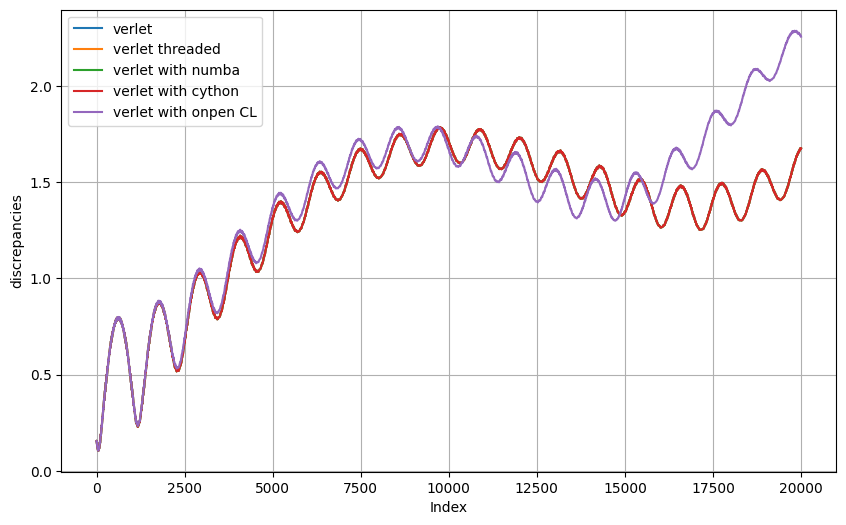

In [33]:
plt.figure(figsize=(10, 6))
#t = np.arange(dif_velet.shape[0])
plt.plot(dif_velet, label=f'verlet')
plt.plot(dif_velet_thr, label=f'verlet threaded')
plt.plot(dif_velet_numba, label=f'verlet with numba')
plt.plot(dif_velet_cython, label=f'verlet with cython')
plt.plot(dif_velet_cl, label=f'verlet with onpen CL')

plt.xlabel('Index')
plt.ylabel('discrepancies')
#plt.title('Magnitude of 2D Vectors')
plt.legend()
plt.grid(True)

### Performance

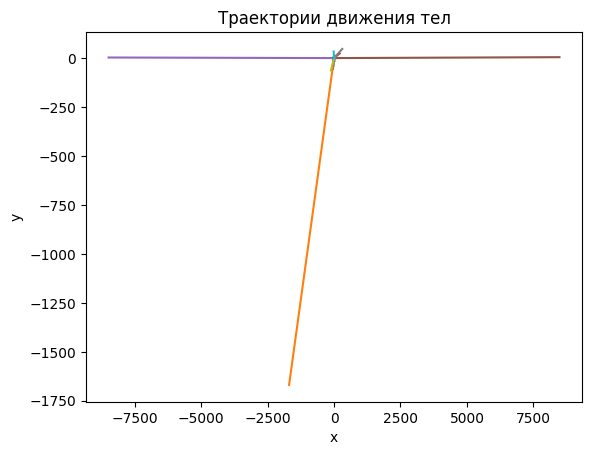

In [38]:
n = 50
masses = 1e-5 * np.ones(n)
seed = 42
initial_conditions = generate_n_body_initial_conditions(n, seed)

T_max = 10
dt = 0.01
steps = int(T_max / dT)
positions = initial_conditions[:, :2]
velocities = initial_conditions[:, 2:]
trajectories = verlet_integration(n, masses.copy(), positions, velocities, dT, steps)
# trajectories = verlet_integration_numba(n, masses.copy(), positions, velocities, dT, steps)
# trajectories = verlet_integration_opencl(n, masses.copy(), positions, velocities, dT, steps)
# trajectories = verlet_integration_numba(n, masses.copy(), positions, velocities, dT, steps)
# if __name__ == "__main__":
#     trajectories = verlet_integration_threaded(n, masses, positions, velocities, dT, steps)

# Пример вывода координат первого тела
for i in range(n):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1])

#plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Траектории движения тел")
plt.show()

In [36]:
functions = [verlet_integration, verlet_integration_threaded, verlet_integration_numba, verlet_integration_cython, verlet_integration_opencl]
function_names = [f.__name__ for f in functions]

Ns = [100, 200, 400]
seed = 42
initial_conditions =[]
masses = []
for i in range(len(Ns)):
    initial_conditions.append(generate_n_body_initial_conditions(Ns[i], seed))
    masses.append(1e-5 * np.ones(Ns[i]))

T_max = 10
dT = 0.01
steps = int(T_max / dT)

input_sets = [
    (Ns[0], masses[0].copy(), initial_conditions[0][:,:2], initial_conditions[0][:,2:], dT, steps),
    (Ns[1], masses[1].copy(), initial_conditions[1][:,:2], initial_conditions[1][:,2:], dT, steps),
    (Ns[2], masses[2].copy(), initial_conditions[2][:,:2], initial_conditions[2][:,2:], dT, steps)
]

input_labels = ["100 bodies", "200 bodies", "400 bodies"]

# Benchmarking
times = np.zeros((len(functions), len(input_sets)))

In [ ]:
import time

for i, func in enumerate(functions):
    for j, input_data in enumerate(input_sets):
        durations = []
        for _ in range(3):  # Run each function 3 times
            start = time.perf_counter()
            if i != 1:
                func(*input_data)
            else:
                if __name__ == "__main__":
                    func(*input_data)
            end = time.perf_counter()
            durations.append(end - start)
        print(i,j)
        times[i, j] = np.mean(durations)

KeyboardInterrupt: 

In [ ]:
np.save(f"times.npy", times)

In [ ]:
# Plotting
x = np.arange(len(input_sets))
width = 0.15  # widt h of the bars

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(functions)):
    ax.bar(x + i * width, times[i], width, label=function_names[i])

ax.set_ylabel('Average Time (s)')
ax.set_title('Function Performance Scaling')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(input_labels)
ax.legend()

plt.tight_layout()
plt.show()